In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
train = pd.read_csv("training.csv")

In [4]:
train

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,C50411,Malig neoplm of upper-outer quadrant of right ...,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,C50912,Malignant neoplasm of unspecified site of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,1749,"Malignant neoplasm of breast (female), unspeci...",...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


In [5]:
train.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

In [6]:
train['Division'].unique()

array(['Pacific', 'West South Central', 'Mountain', 'Middle Atlantic',
       'East North Central', nan, 'East South Central', 'South Atlantic',
       'West North Central', 'New England'], dtype=object)

Variables (likely to affect diagnosis) to transform:
- `patient_race`: encode to discrete values
- `payer_type`: encode
- `patient_state`: encode
- `patient_zip3`: encode
- `patient_gender`: encode
- `bmi`: standardize
- `breast_cancer_diagnosis_code`: encode
- `breast_cancer_diagnosis_code_desc`: potentially transform with NLP
- `metastatic_cancer_diagnosis_code`: encode
- `metastatic_first_novel_treatment`: encode
- `metastatic_first_novel_treatment_type`: encode (or potentially drop since there is only one value -- check if this is only populated when a `metastatic_first_novel_treatment` exists)
- `Region`: encode
- `Division`: encode (is this repeating info from zip code?)
- `population`: standardize (is this needed if density is given?)
- `density`: standardize
- `family_size`: standardize
- `income_household_median`: standardize
- `ozone`: standardize
- `PM25`: standardize
- `N02`: standardize



Consider:
- technique to determine which variables are/aren't strong predictors of diagnosis
- replace zip code with latitude and longitude so that they're easier to deal with - allows for predictions with new zipcodes (not possible through just encoding) and helpful for tree models

In [8]:
train_dummies = pd.get_dummies(train)

**Feature Selection**

In [17]:
# split train into X and y
X_train = train_dummies[[col for col in train_dummies.columns if col != 'DiagPeriodL90D']]
X_train.drop(columns=['patient_id'], inplace=True)
y_train = train_dummies['DiagPeriodL90D']

/var/folders/yk/hhtpxrf148s9kplf84g3rqzm0000gn/T/ipykernel_93536/912122293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['patient_id'], inplace=True)


In [18]:
# fit XGB model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

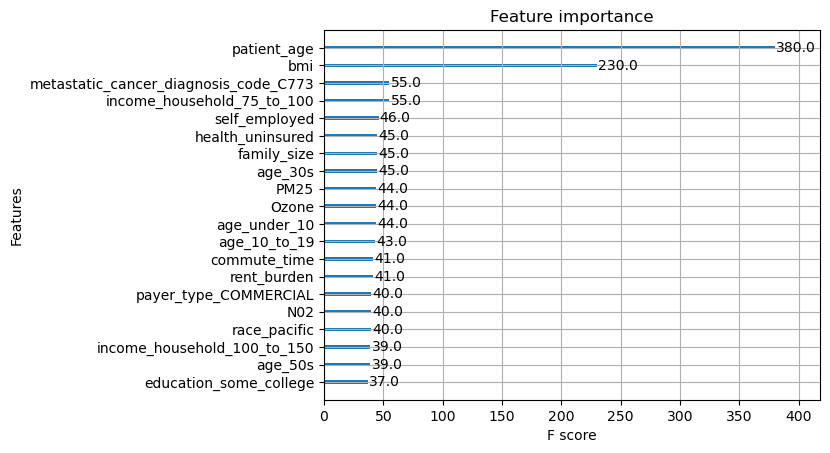

In [19]:
plot_importance(model, max_num_features=20)

**EDA**

In [5]:
train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


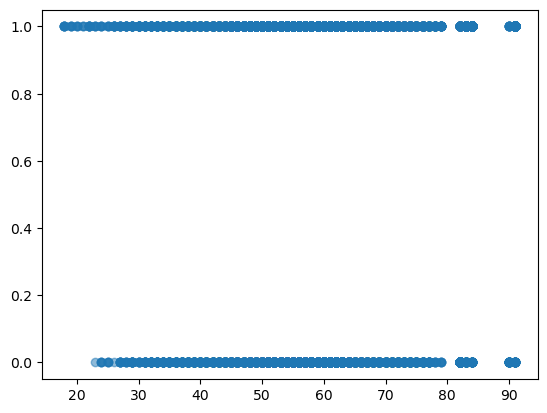

In [10]:
plt.scatter(train['patient_age'], train['DiagPeriodL90D'], alpha=0.5)